In [1]:
import pandas as pd
filename = r'C:\tmp\data\Nanopore data Waad Tombo files\Own601-data\barcode10CP10.xlsx'
filename = r'C:\tmp\data\Nanopore data Waad Tombo files\barcode04_Waad601.xlsx'
# filename = r'C:\tmp\data\Nanopore data Waad Tombo files\barcode05_WaadR1.xlsx'
# filename = r'C:\tmp\data\Nanopore data Waad Tombo files\barcode06_WaadR2.xlsx'

df = pd.read_excel(filename)
colors = ['red', 'green', 'blue', 'orange',
          'purple', 'cyan', 'magenta', 'yellow', 'brown']
title = filename.split('\\')[-1]+'\n'

In [2]:
# discard reads that lack more than X bps on either end

X = 200
start = len(df.columns)
df = df.loc[:, ~(df.iloc[:X].isna().all() | df.iloc[-X:].isna().all())]
print(start, " > ",  len(df.columns))

647  >  163


In [3]:
# Compute compound LLR by summing over a window of 147 bp; normalize by number of potential methylation sites in window

from tqdm import tqdm
import numpy as np

window = 147
llr_df = df.copy()

for col in tqdm(df.columns):
    llr_df[col] = np.roll(df[col].rolling(window=window, min_periods=1).sum() / df[col].rolling(window=window, min_periods=1).count(), -window//2)

# discard values at the end of the chromosome
llr_df[df.index > len(df) - window//2] = np.nan

100%|██████████| 163/163 [00:01<00:00, 147.01it/s]


In [4]:
# Convert LLR to probability to nulcesomse occupancy using Vanderlick's formula
# https://doi.org/10.1103/PhysRevA.34.5130
# LLR should be converted to a free energy landscape, using DeltaG for nucleosome formation

import numpy as np


def vanderlick(llr, multiplier=-1, delta_g=10, handles=1000, convolve=147, energy_landscape=None):

    llr = np.concatenate([np.zeros(handles), llr, np.zeros(handles)])
    llr = np.nan_to_num(llr)
    n = len(llr)

    if energy_landscape is None:
        energy_landscape = llr*multiplier + delta_g
    footprint = 147

    forward = np.zeros(n)
    for i in range(n):
        tmp = sum(forward[max(i - footprint, 0):i])
        forward[i] = np.exp(-energy_landscape[i] - tmp)

    backward = np.zeros(n)
    r_forward = forward[::-1]
    for i in range(n):
        backward[i] = 1 - sum(r_forward[max(i - footprint, 0):i]
                              * backward[max(i - footprint, 0):i])

    P = forward * backward[::-1]

    if convolve > 1:
        kernel = np.ones(convolve)/convolve
        P = convolve*np.convolve(P, kernel, mode='same')
        P = np.clip(P, 0, 1)
    return P[handles:-handles]

In [5]:
# randomly select a couple of reads
colors = ['red', 'green', 'blue', 'orange',
          'purple', 'cyan', 'magenta', 'yellow', 'brown']

selected = df.columns[np.random.randint(0, len(df.columns), len(colors))]

In [6]:
# import SciencePlots
import matplotlib.pyplot as plt

plt.style.use(['science', 'notebook'])

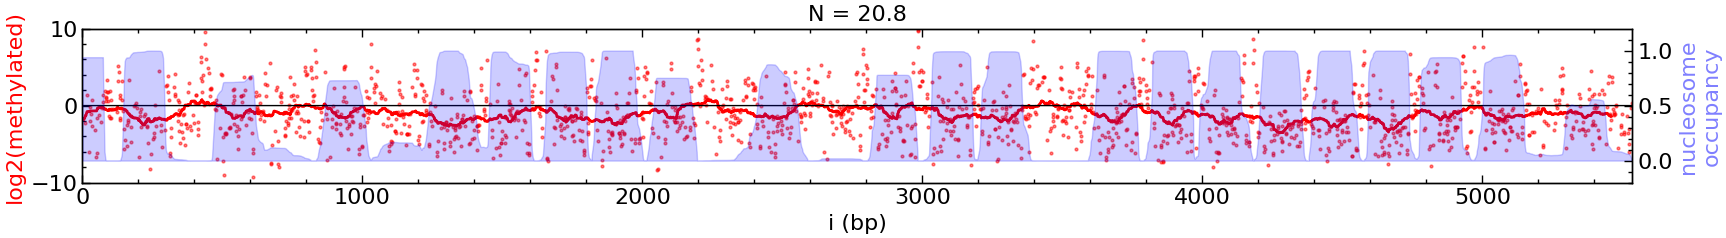

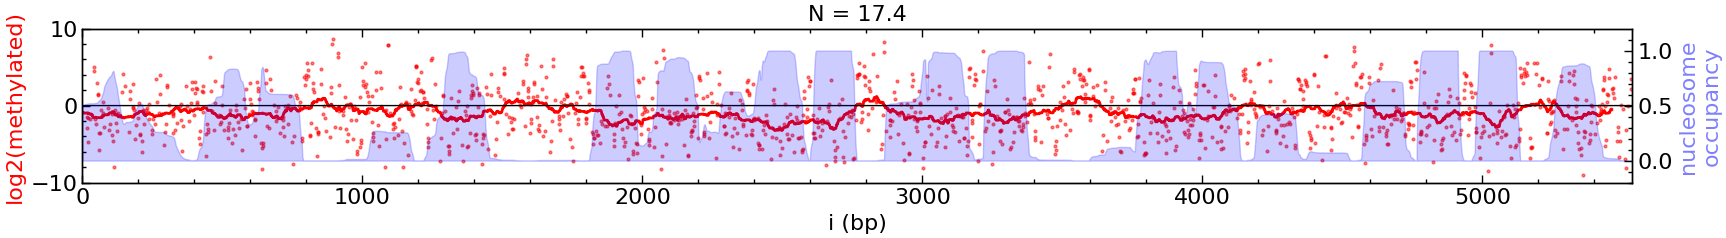

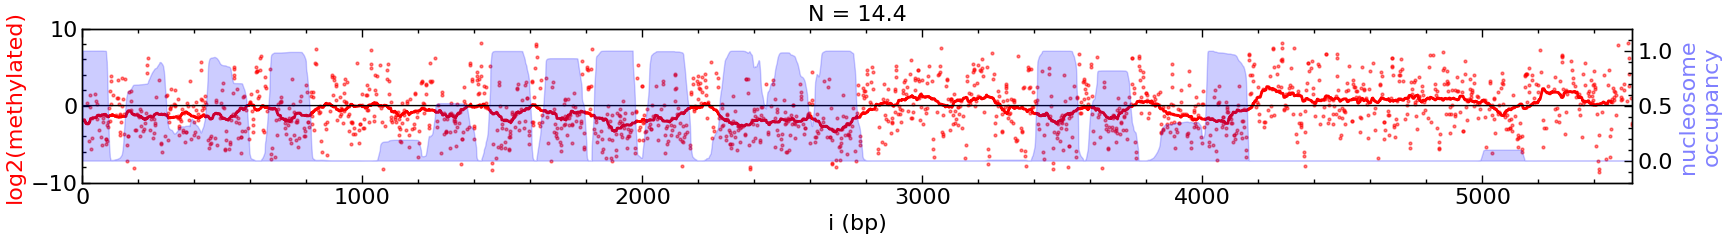

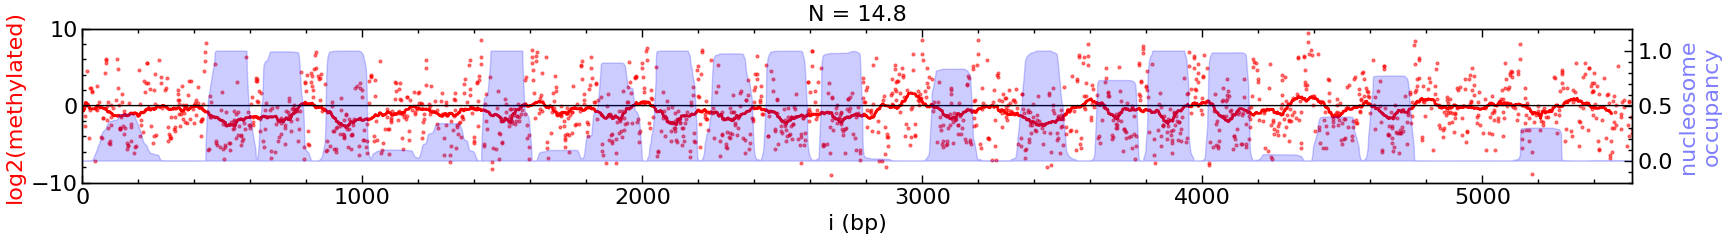

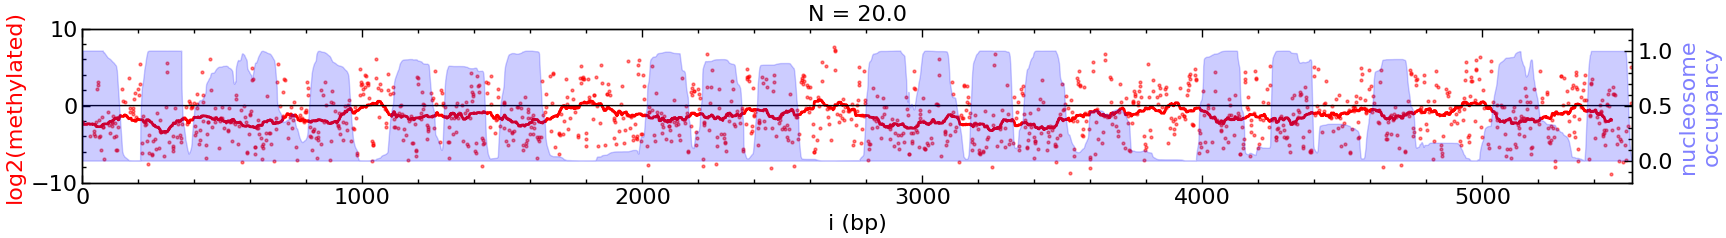

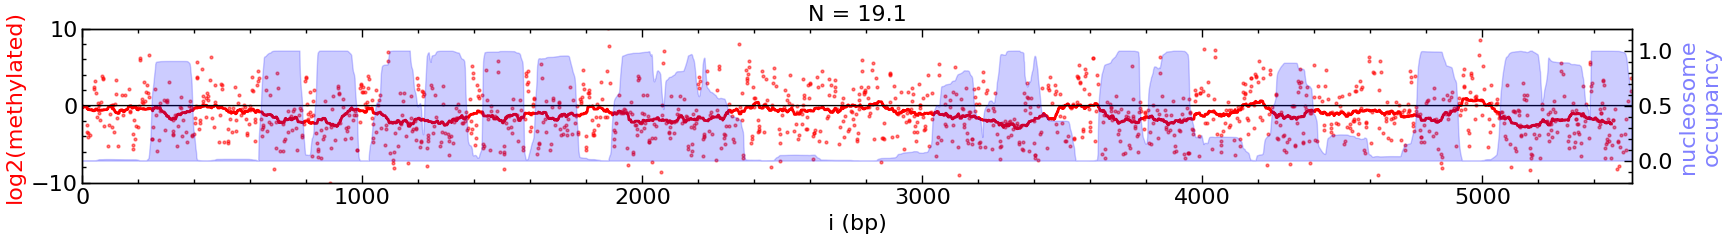

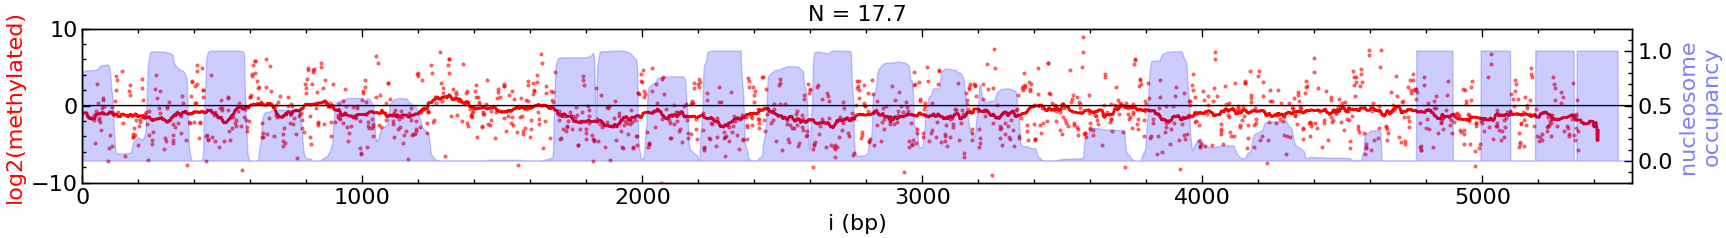

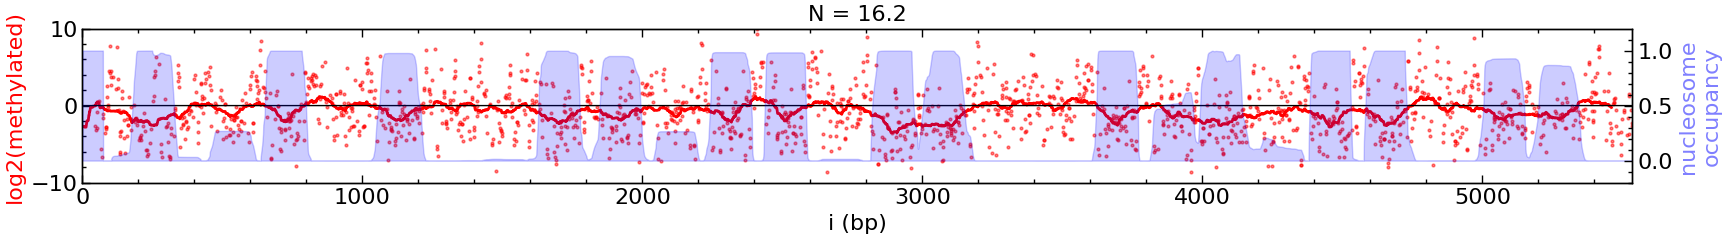

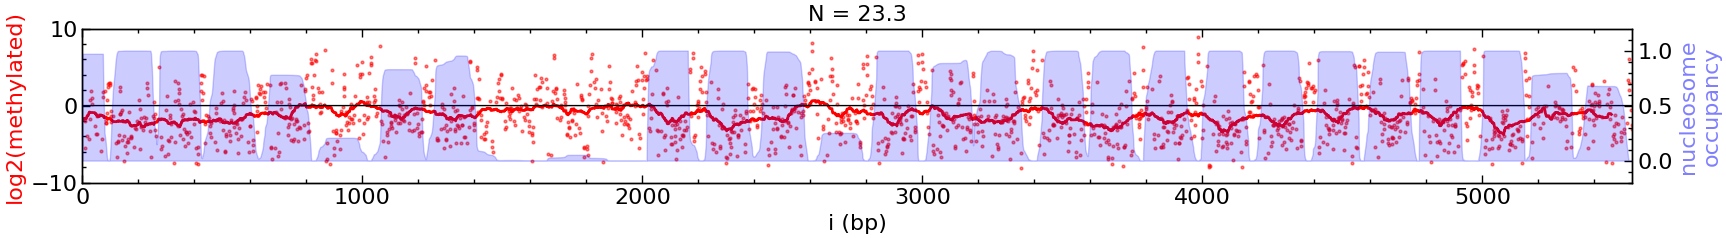

In [7]:
# Plot a couple of examples
import matplotlib.pyplot as plt

dg = 15
multiplier = -8
xlim = [0, len(df)]
base_index = np.arange(len(llr_df))

for i, c in enumerate(selected):
    colors[i] = 'red'
    fig, ax1 = plt.subplots()
    # plot log likelihood ratio of methylation; not absence of methylation
    ax1.plot(-df[c], 'o', markersize=2, alpha=0.5, color=colors[i])
    ax1.plot(-llr_df[c], color=colors[i])
    ax1.plot(np.zeros(len(llr_df[c])), color='black', linewidth=1)
    # ax1.plot(-1.8*np.ones(len(llr_df[c])), '--', color = 'black', linewidth = 1)
    ax1.set_ylabel(f'log2(methylated)', color = colors[i])
    ax1.set_ylim(-10, 10)
    plt.xlabel('i (bp)')
    plt.xlim(*xlim)
    ax2 = ax1.twinx()
    occupancy = vanderlick(
        llr_df[c], multiplier=multiplier, delta_g=dg, convolve=window)
    # ax2.fill_between(base_index, occupancy, color=colors[i], alpha=0.2)
    ax2.fill_between(base_index, occupancy, color='blue', alpha=0.2)
    ax2.set_ylim(-0.2, 1.2)
    ax2.set_ylabel(f'nucleosome\noccupancy', color = 'blue', alpha = 0.5)
    plt.title(f'N = {len(occupancy[occupancy>0.5])/window:.1f}')

    plt.gcf().set_size_inches(20, 2)
    plt.show()

In [8]:
# Convert LLR to nucleosome occupancy

nuc_df = llr_df.copy()
for c in tqdm(llr_df.columns):
    nuc_df[c] = vanderlick(llr_df[c], multiplier=multiplier,
                           delta_g=dg, convolve=window)

  0%|          | 0/163 [00:00<?, ?it/s]

100%|██████████| 163/163 [00:48<00:00,  3.38it/s]


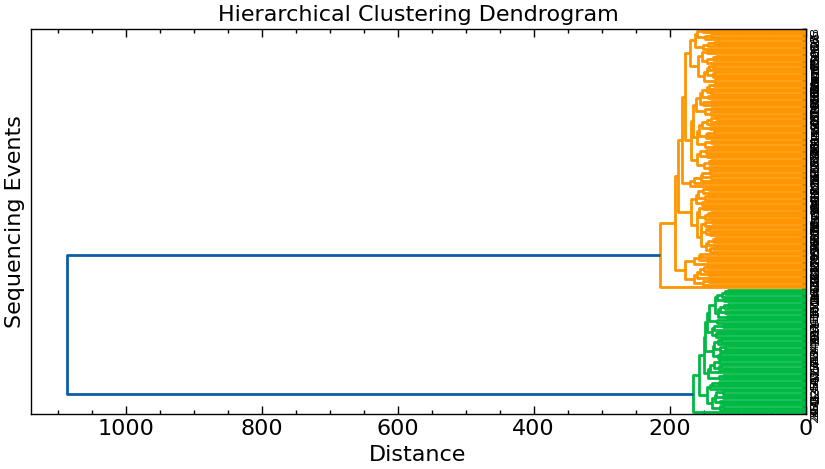

In [9]:
# Compute dendogram

from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(df.fillna(0).T, method='ward')
clustering_order = dendrogram(Z, no_plot=True)['leaves']

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Sequencing Events')
dendrogram(Z, orientation='left', leaf_rotation=90., leaf_font_size=8.)
plt.show()

In [10]:
# Get cluster boundaries from the dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

n_clusters = 2
clusters = fcluster(Z, n_clusters, criterion='maxclust')
clusters = clusters[clustering_order]
boundaries = np.where(np.diff(clusters))[0] + 1
print('Boundaries:', boundaries)

Boundaries: [53]


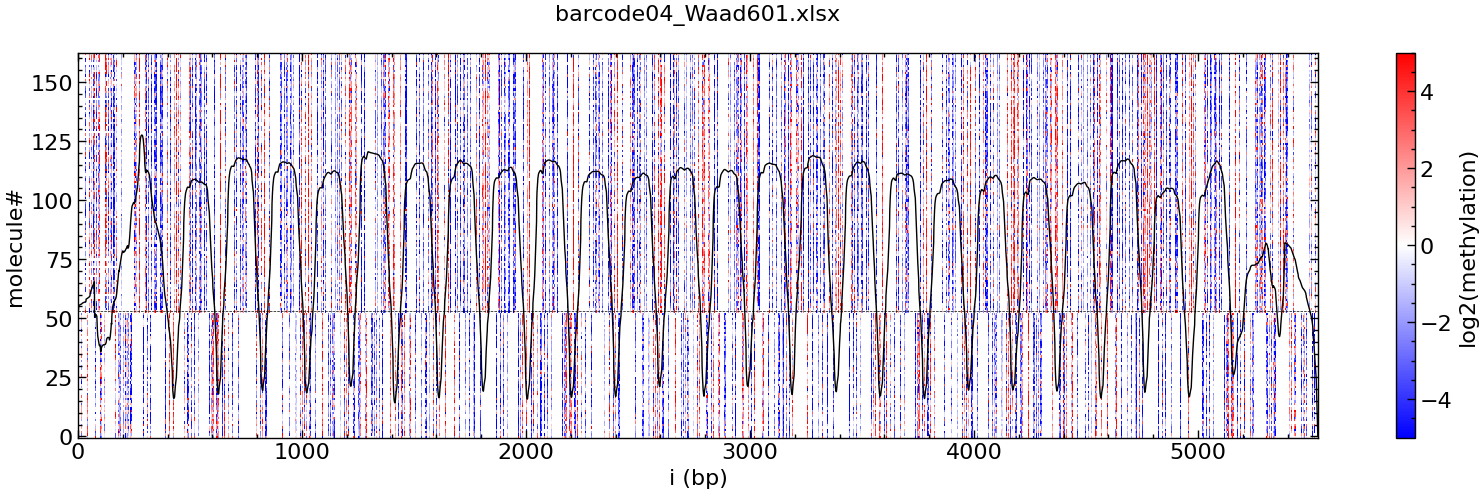

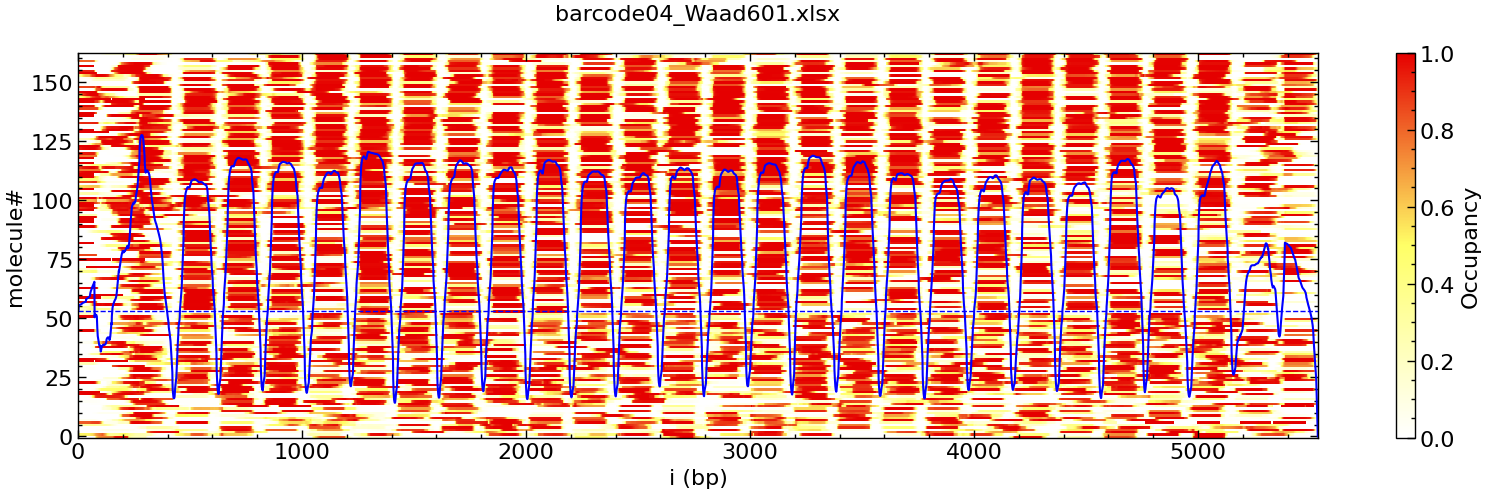

In [11]:
# plot the nucleosome occupancy matrix, ordered by the dendogram

from matplotlib.colors import LinearSegmentedColormap
xlim = np.asarray([0, 3])*197 + 3000
xlim = [0, len(df)]

# plot the methylation matrix, ordered by the dendogram
im = plt.imshow(-df.iloc[:, clustering_order].swapaxes("index", "columns"), cmap='bwr',
                interpolation='nearest', vmin=-5, vmax=5, origin='lower', aspect='auto')
plt.ylabel(f'molecule#')
plt.xlabel('i (bp)')
cbar = plt.colorbar(im)
cbar.set_label('log2(methylation)', rotation=90)
plt.plot(len(nuc_df.columns)*nuc_df.mean(axis=1), color='black', linewidth=1.0)
plt.title(title)
plt.gcf().set_size_inches(20, 5)
plt.xlim(xlim)

# Draw lines at cluster boundaries
for boundary in boundaries:
    plt.axhline(boundary, color='k', linewidth=0.5, linestyle='--')
plt.show()

# Create custom coloromap for occupancy
cmap_name = 'WhiteToRed'
colors = [(1, 1, 1), (1, 1, 0.4), (0.9, 0, 0)]  # White to Red
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# plot the occupancy matrix, ordered by the dendogram
im = plt.imshow(nuc_df.iloc[:, clustering_order].swapaxes("index", "columns"),
                cmap=cmap, interpolation='nearest', vmin=0, vmax=1, origin='lower', aspect='auto')
plt.ylabel(f'molecule#')
plt.xlabel('i (bp)')
cbar = plt.colorbar(im)
cbar.set_label('Occupancy', rotation=90)
plt.plot(len(nuc_df.columns)*nuc_df.mean(axis=1), color='blue', linewidth=1.5)
plt.title(title)
plt.gcf().set_size_inches(20, 5)
plt.xlim(xlim)

# Draw lines at cluster boundaries
for boundary in boundaries:  # Draw lines for the first five clusters
    plt.axhline(boundary, color='blue', linewidth=1.0, linestyle='--')

plt.show()

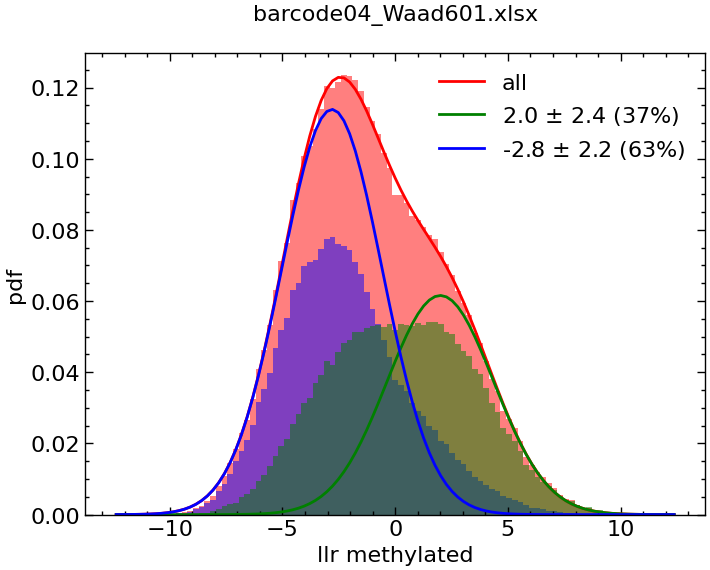

In [12]:
# statistics of methylation, no nucleosome windowing
from scipy.optimize import curve_fit


def double_gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
    return a1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) + a2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))


selection = [nuc_df > 0, nuc_df > 0.5, nuc_df < 0.5]
p0 = [0.2, -2, 2, 0.3, 1, 2]
lower_bounds = [0.01, -4, 0.5, 0.01, -4, 0.5]
upper_bounds = [0.99, 4, 5, 0.99, 4, 5]
colors = ['red', 'blue', 'green']

edges = np.linspace(-12.5, 12.5, 100)
bins = (edges[:-1] + edges[1:])/2
for i, s in enumerate(selection):
    hist, _ = np.histogram(-df[s].fillna(-10000), bins=edges)
    if i == 0:
        normalization = np.sum(hist) * (bins[1]-bins[0])
        try:
            p, pcov = curve_fit(double_gaussian, bins, hist/normalization,
                                p0=p0, bounds=(lower_bounds, upper_bounds))
            fraction = p[0]*p[2] / (p[0]*p[2] + p[3]*p[5])
            plt.plot(bins, double_gaussian(bins, *p),
                     color=colors[i], linewidth=2, label='all')
            plt.plot(bins, double_gaussian(
                bins, *(p*np.asarray([0, 1, 1, 1, 1, 1]))), color=colors[2], linewidth=2, label=f'{p[4]:.1f} $\pm$ {p[5]:.1f} ({1-fraction:.0%})')
            plt.plot(bins, double_gaussian(
                bins, *(p*np.asarray([1, 1, 1, 0, 1, 1]))), color=colors[1], linewidth=2, label=f'{p[1]:.1f} $\pm$ {p[2]:.1f} ({fraction:.0%})')
        except RuntimeError:
            print('fitting failed')

    plt.bar(bins, hist/normalization,
            color=colors[i], alpha=0.5, align='center', width=bins[1]-bins[0])

plt.xlabel('llr methylated')
plt.ylabel('pdf')
plt.title(title)
plt.legend()
plt.show()

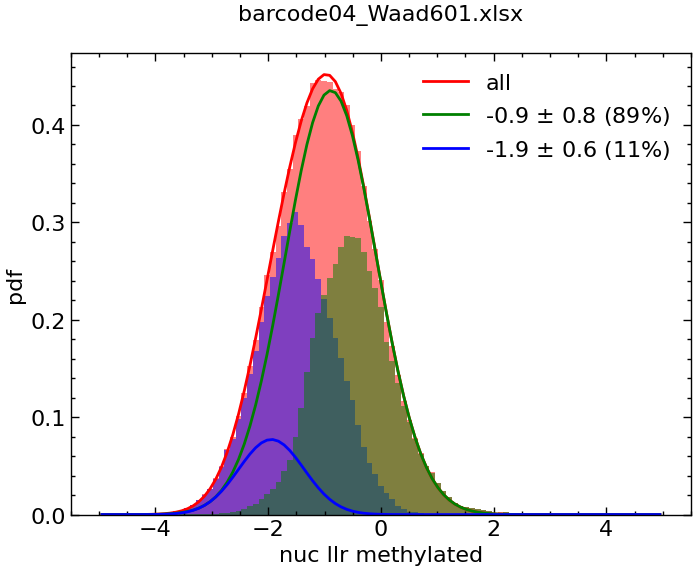

In [13]:
# statistics of methylation, with nucleosome windowing

p0 = [0.5, -2, 1, 0.5, 0, 1]
edges = np.linspace(-5, 5, 100)
bins = (edges[:-1] + edges[1:])/2
for i, s in enumerate(selection):
    hist, _ = np.histogram(-llr_df[s].fillna(-10000), bins=edges)
    if i == 0:
        normalization = np.sum(hist) * (bins[1]-bins[0])
        p, pcov = curve_fit(double_gaussian, bins, hist/normalization,
                            p0=p0, bounds=(lower_bounds, upper_bounds))
        fraction = p[0]*p[2] / (p[0]*p[2] + p[3]*p[5])
        plt.plot(bins, double_gaussian(bins, *p),
                 color=colors[i], linewidth=2, label='all')
        plt.plot(bins, double_gaussian(bins, *(p*np.asarray([0, 1, 1, 1, 1, 1]))),
                 color=colors[2], linewidth=2, label=f'{p[4]:.1f} $\pm$ {p[5]:.1f} ({1-fraction:.0%})')
        plt.plot(bins, double_gaussian(bins, *(p*np.asarray([1, 1, 1, 0, 1, 1]))),
                 color=colors[1], linewidth=2, label=f'{p[1]:.1f} $\pm$ {p[2]:.1f} ({fraction:.0%})')
    plt.bar(bins, hist/normalization,
            color=colors[i], alpha=0.5, align='center', width=bins[1]-bins[0])

plt.xlabel('nuc llr methylated')
plt.ylabel('pdf')
plt.legend()
plt.title(title)
plt.show()

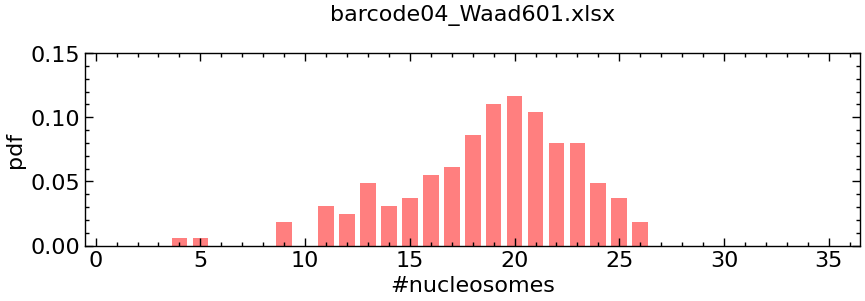

In [14]:
# count number of nucleosomes per read

window = 147
counts = nuc_df[nuc_df > 0.5].count()/window
bins = np.arange(0, len(df)//window, 1)

hist, _ = np.histogram(counts, bins=bins, density=True)

# Plotting the histogram
plt.bar(bins[:-1], hist, color=colors[0],
        alpha=0.5, align='center', width=0.75)
plt.xlabel('#nucleosomes')
plt.ylabel('pdf')
plt.title(title)
plt.xlim(-0.5, np.max(bins)+0.5)
plt.ylim(0, 0.15)
plt.gcf().set_size_inches(10, 2.5)
plt.show()